Nicole Lim | IS 665-852 | Project 2 | PS2 vs. PSP (Sony Consoles Comparison)

Import Libraries and Load the Dataset

In [ ]:
# Nicole Lim - IS 665-852 Project 2 - Apr 29, 2025 Emphasis on PS2 vs. PSP (Sony consoles comparison)

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.inspection import permutation_importance

from google.colab import files
uploaded = files.upload()

#Link to video game sales dataset: https://www.kaggle.com/datasets/gregorut/videogamesales, but this was cleaned to only include PS2 and PSP
df = pd.read_csv('cleaned_vgsales.csv')

Saving cleaned_vgsales.csv to cleaned_vgsales.csv


Processing the Data

In [ ]:
class ProcessData:
    def __init__(self):
        df = pd.read_csv("cleaned_vgsales.csv")  # Read the raw dataset
        self.df = df[df['Platform'].isin(['PSP', 'PS2'])].copy()  # Only contain information on 2 Main Sony Platforms and create a copy
        print(f"Null Information:\n{self.df.isnull().sum()}")

    def visualize_null_values(self, outlier=False):
        if outlier:
            plt.figure(1)  # Explicitly create figure 1
            plt.clf()  # Clear any existing content in figure 1
            sns.boxplot(self.df['Global_Sales'], color='orange')
            plt.title('Outlier Detection in Global Sales')
            plt.xlabel('Global Sales')
            plt.tight_layout()
            plt.show()
            print('-' * 100)
        else:
            plt.figure(2)  # Explicitly create figure 2
            plt.clf()  # Clear any existing content in figure 2
            sns.heatmap(self.df.isnull(), cbar=False, cmap='viridis')
            plt.title("Missing Values")
            plt.tight_layout()
            plt.show()
            print('\n')

    def process_null_values(self):
        """
        Drop the records for Publisher where the values are NaN (Do not need to incorporate in model)
        Take the previous year into account for NaN values for Year Column
        """
        self.df = self.df.dropna(subset=['Publisher']).copy()  # Create a copy after dropping NaNs
        self.df['Year'] = self.df['Year'].ffill()

        # Convert the data type for Year back to INT
        self.df['Year'] = self.df['Year'].astype(int)

    def remove_outlier(self):
        return self.df[self.df['Global_Sales'] < 9]

Null Information:
Rank            0
Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64


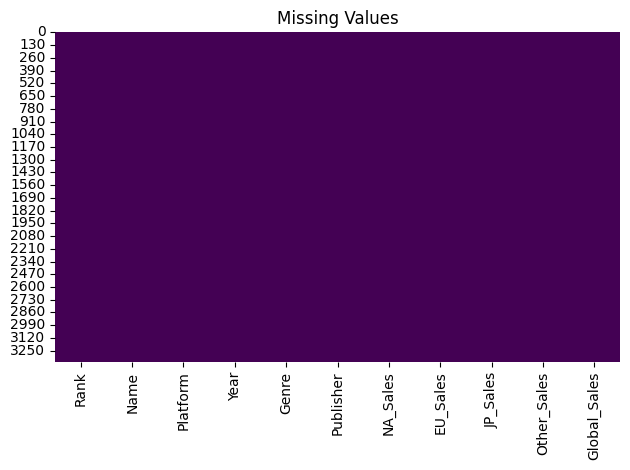

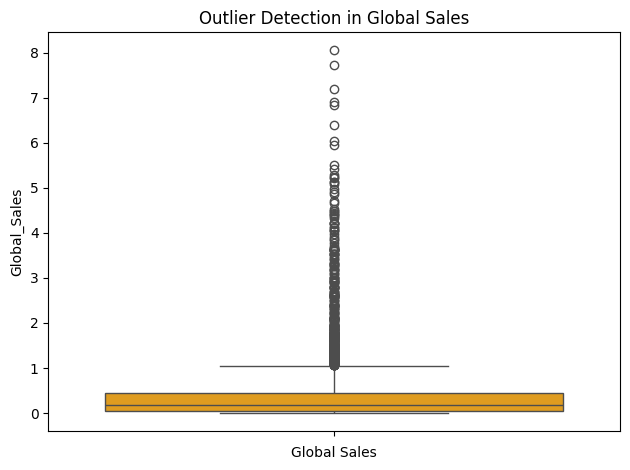

----------------------------------------------------------------------------------------------------


In [ ]:
# Visualize and process the NaN values (ensuring the cleaned dataset is truly clean)

process = ProcessData()
process.visualize_null_values()  # Visualize the NaN values in the Heatmap
process.process_null_values()  # Process the NaN values
process.visualize_null_values(outlier=True)  # Visualize the outlier through BoxPlot
df_cleaned = process.remove_outlier()

In [ ]:
# For PSP and PS2 to be individual datasets
df_psp = df_cleaned[df_cleaned['Platform'].isin(['PSP'])].copy()
df_ps2 = df_cleaned[df_cleaned['Platform'].isin(['PS2'])].copy()

Visualize the PSP data

Mean Squared Error on the PSP test set: 0.01
Root Mean Squared Error: 0.07
R-squared: 0.94


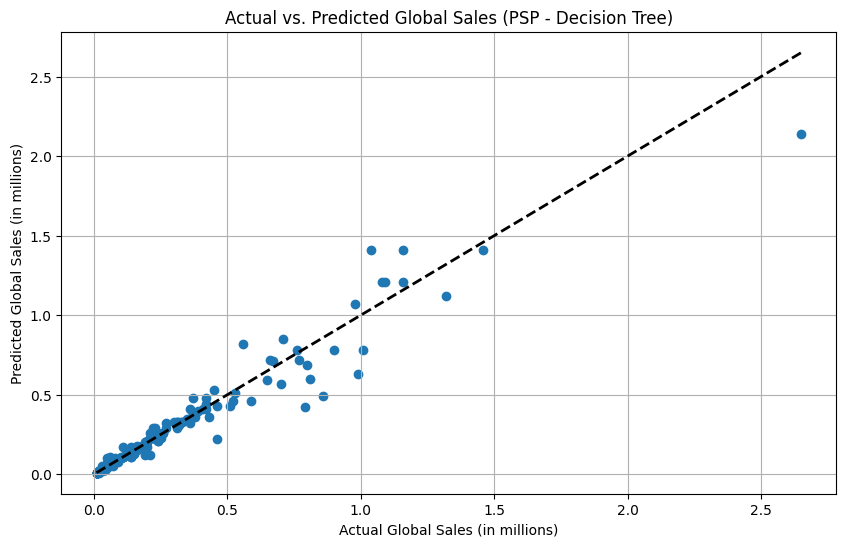

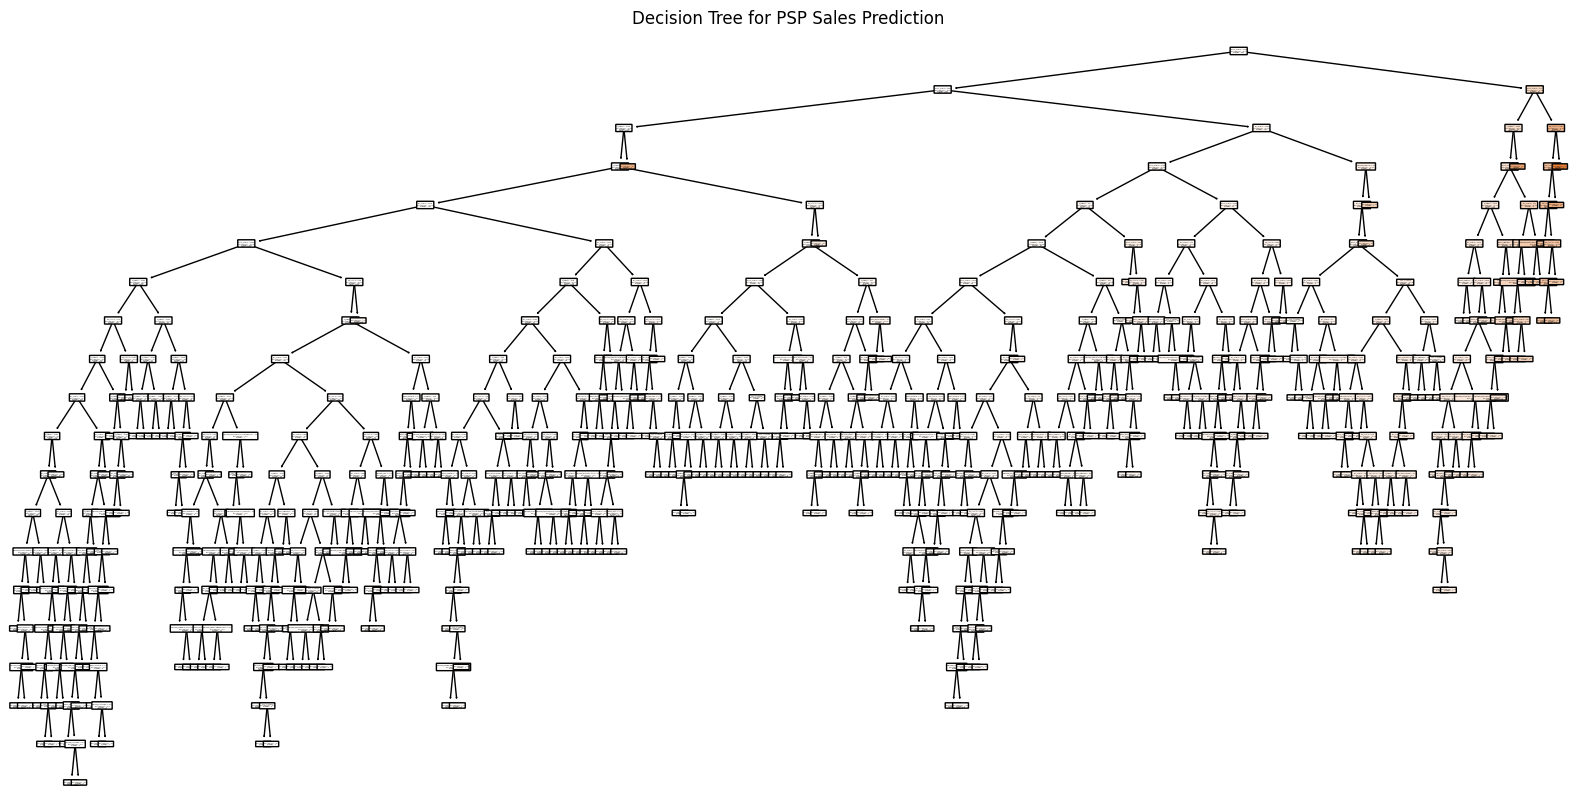

In [ ]:
# Define the features (X) and the target variable (y)
# Using the available fields: 'Year', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'
features = ['Year', 'Genre', 'Publisher', 'NA_Sales'] #, 'EU_Sales', 'JP_Sales', 'Other_Sales'
target = 'Global_Sales'

# Convert categorical features into numerical using one-hot encoding
sony_df_encoded = pd.get_dummies(df_psp, columns=['Genre', 'Publisher'], drop_first=True)

# Select the encoded features
# Be careful to select only the columns that are now numerical features
X = sony_df_encoded[[col for col in sony_df_encoded.columns if col not in ['Rank', 'Name', 'Platform', target]]]
y = sony_df_encoded[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Regressor
decision_tree = DecisionTreeRegressor(random_state=42)
decision_tree.fit(X_train, y_train)

# Make predictions on the test set
y_pred = decision_tree.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error on the PSP test set: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

# Plotting the results (Predicted vs. Actual Sales)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Global Sales (in millions)')
plt.ylabel('Predicted Global Sales (in millions)')
plt.title('Actual vs. Predicted Global Sales (PSP - Decision Tree)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line for perfect predictions
plt.grid(True)
plt.show()

# Visualizing the Decision Tree (original tree pre-pruning)
plt.figure(figsize=(20, 10))
plot_tree(decision_tree, feature_names=X.columns, filled=True, rounded=True)
plt.title('Decision Tree for PSP Sales Prediction')
plt.show()

PSP Pruned Tree

Best ccp_alpha: 0.0
Mean Squared Error on the PSP test set (Pruned): 0.04
Root Mean Squared Error: 0.07
R-squared: 0.94


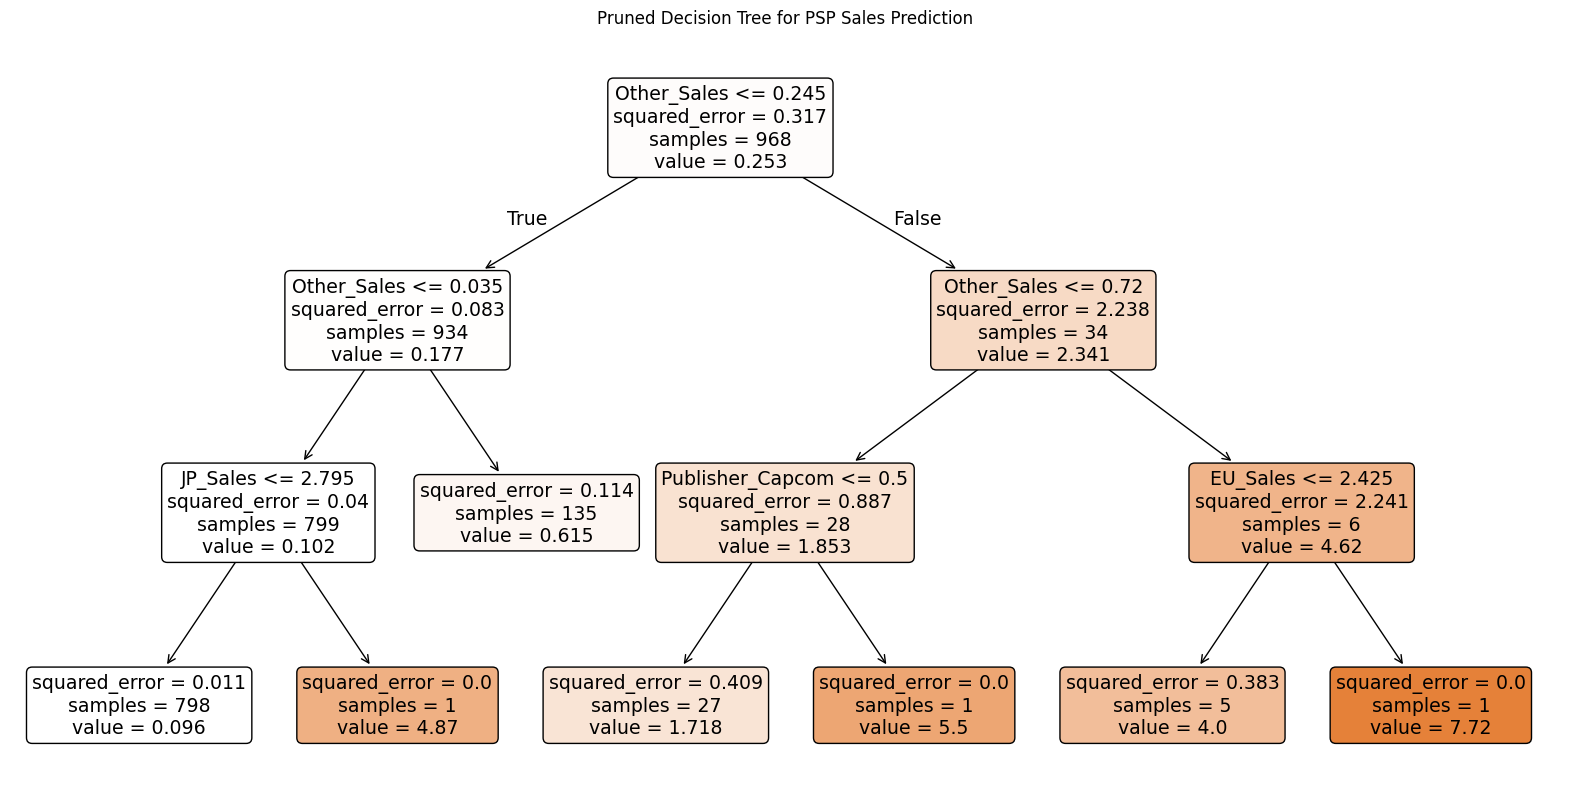

In [ ]:
# Import libraries for post-pruning
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Create a Decision Tree Regressor with hyperparameters
decision_tree = DecisionTreeRegressor(
    max_depth=5,  # Limit tree depth to 5
    min_samples_split=10,  # Require at least 10 samples to split a node
    min_samples_leaf=5,  # Require at least 5 samples in a leaf node
    random_state=42
)

# Define parameter grid for ccp_alpha
param_grid = {
    'ccp_alpha': np.arange(0.0, 0.1, 0.001)  # Explore values between 0 and 0.1
}

# Create and fit GridSearchCV object
tree = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best ccp_alpha value
best_ccp_alpha = grid_search.best_params_['ccp_alpha']
print(f"Best ccp_alpha: {best_ccp_alpha}")

# Create and train the pruned decision tree
# pruned_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=best_ccp_alpha)
pruned_tree = DecisionTreeRegressor(random_state=42, ccp_alpha = 0.01, max_depth = 5)
pruned_tree.fit(X_train, y_train)

# Evaluate the pruned tree
y_pred_pruned = pruned_tree.predict(X_test)
mse_pruned = mean_squared_error(y_test, y_pred_pruned)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error on the PSP test set (Pruned): {mse_pruned:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

# Visualize the pruned decision tree
plt.figure(figsize=(20, 10))
plot_tree(pruned_tree, feature_names=X.columns, filled=True, rounded=True)
plt.title('Pruned Decision Tree for PSP Sales Prediction')
plt.show()



Visualize the PS2 data

Mean Squared Error on the PS2 test set: 0.01
Root Mean Squared Error: 0.10
R-squared: 0.98


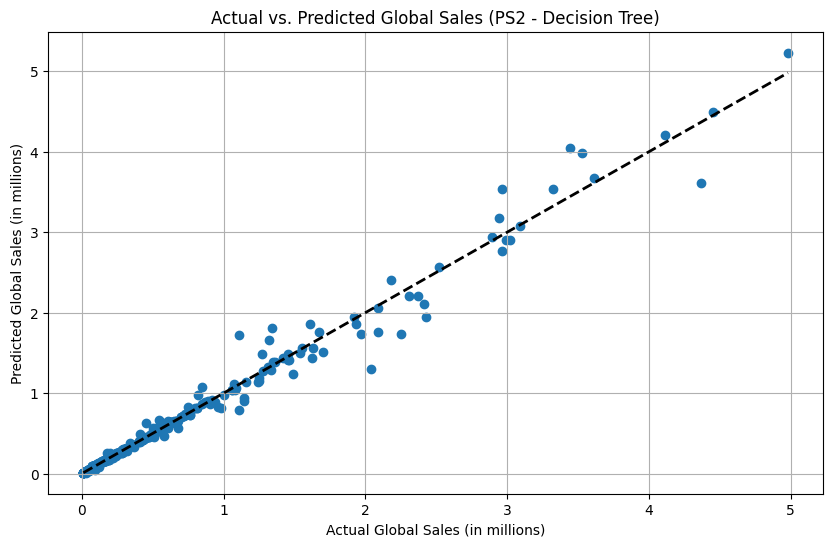

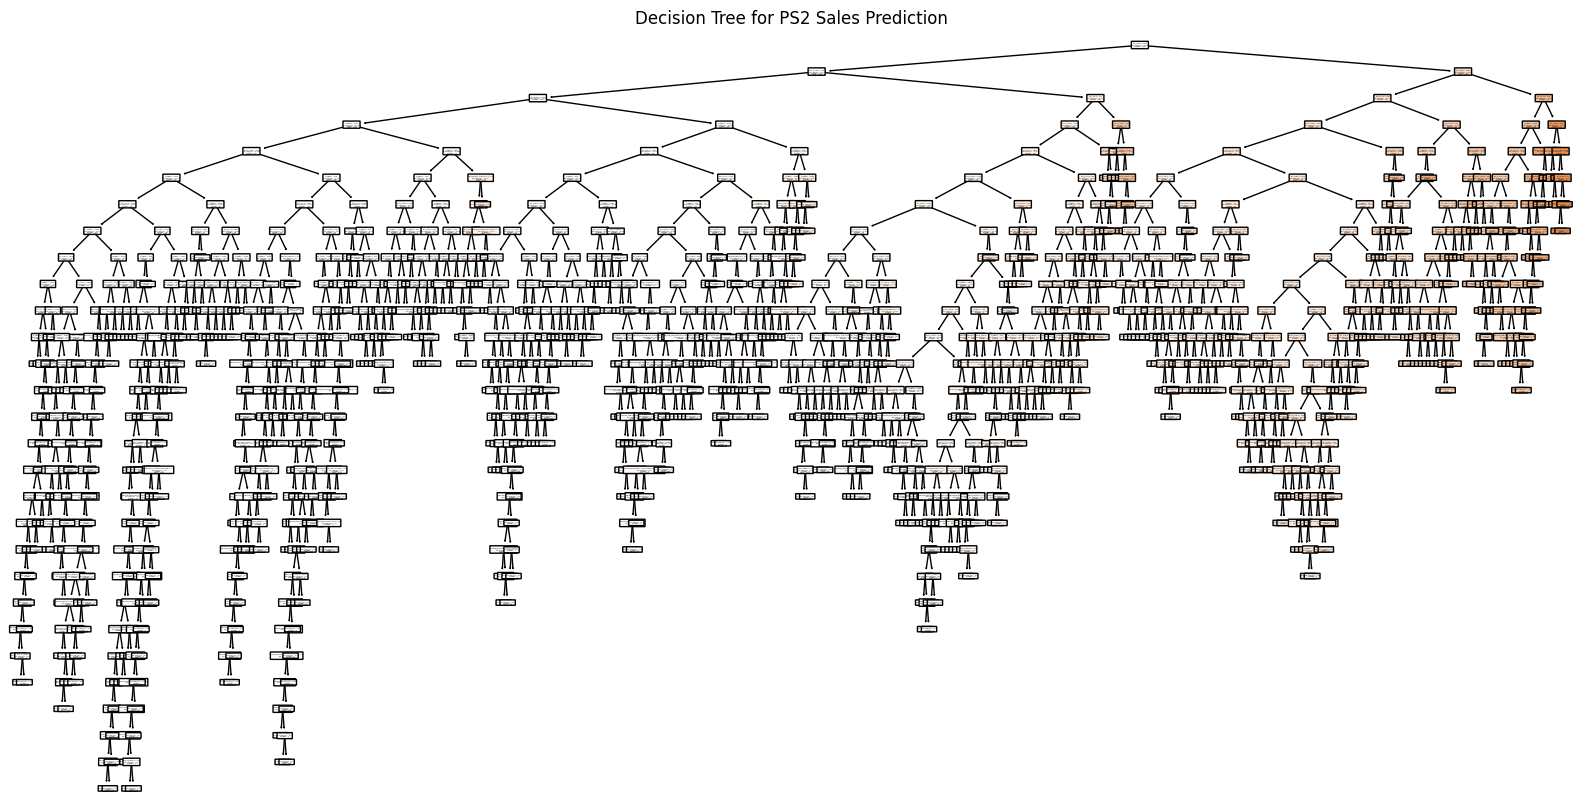

In [ ]:
# Define the features (X) and the target variable (y)
# Using the available fields: 'Year', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'
features = ['Year', 'Genre', 'Publisher', 'NA_Sales'] #, 'EU_Sales', 'JP_Sales', 'Other_Sales'
target = 'Global_Sales'

# Convert categorical features into numerical using one-hot encoding
sony_df_encoded = pd.get_dummies(df_ps2, columns=['Genre', 'Publisher'], drop_first=True)

# Select the encoded features
# Be careful to select only the columns that are now numerical features
X = sony_df_encoded[[col for col in sony_df_encoded.columns if col not in ['Rank', 'Name', 'Platform', target]]]
y = sony_df_encoded[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Regressor
decision_tree = DecisionTreeRegressor(random_state=42)
decision_tree.fit(X_train, y_train)

# Make predictions on the test set
y_pred = decision_tree.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error on the PS2 test set: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

# Plotting the results (Predicted vs. Actual Sales)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Global Sales (in millions)')
plt.ylabel('Predicted Global Sales (in millions)')
plt.title('Actual vs. Predicted Global Sales (PS2 - Decision Tree)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line for perfect predictions
plt.grid(True)
plt.show()

# Visualizing the Decision Tree (original tree pre-pruning)
plt.figure(figsize=(20, 10))
plot_tree(decision_tree, feature_names=X.columns, filled=True, rounded=True)
plt.title('Decision Tree for PS2 Sales Prediction')
plt.show()

PS2 Pruned Tree

Best ccp_alpha: 0.0
Mean Squared Error on the PS2 test set (Pruned): 0.08
Root Mean Squared Error: 0.10
R-squared: 0.98


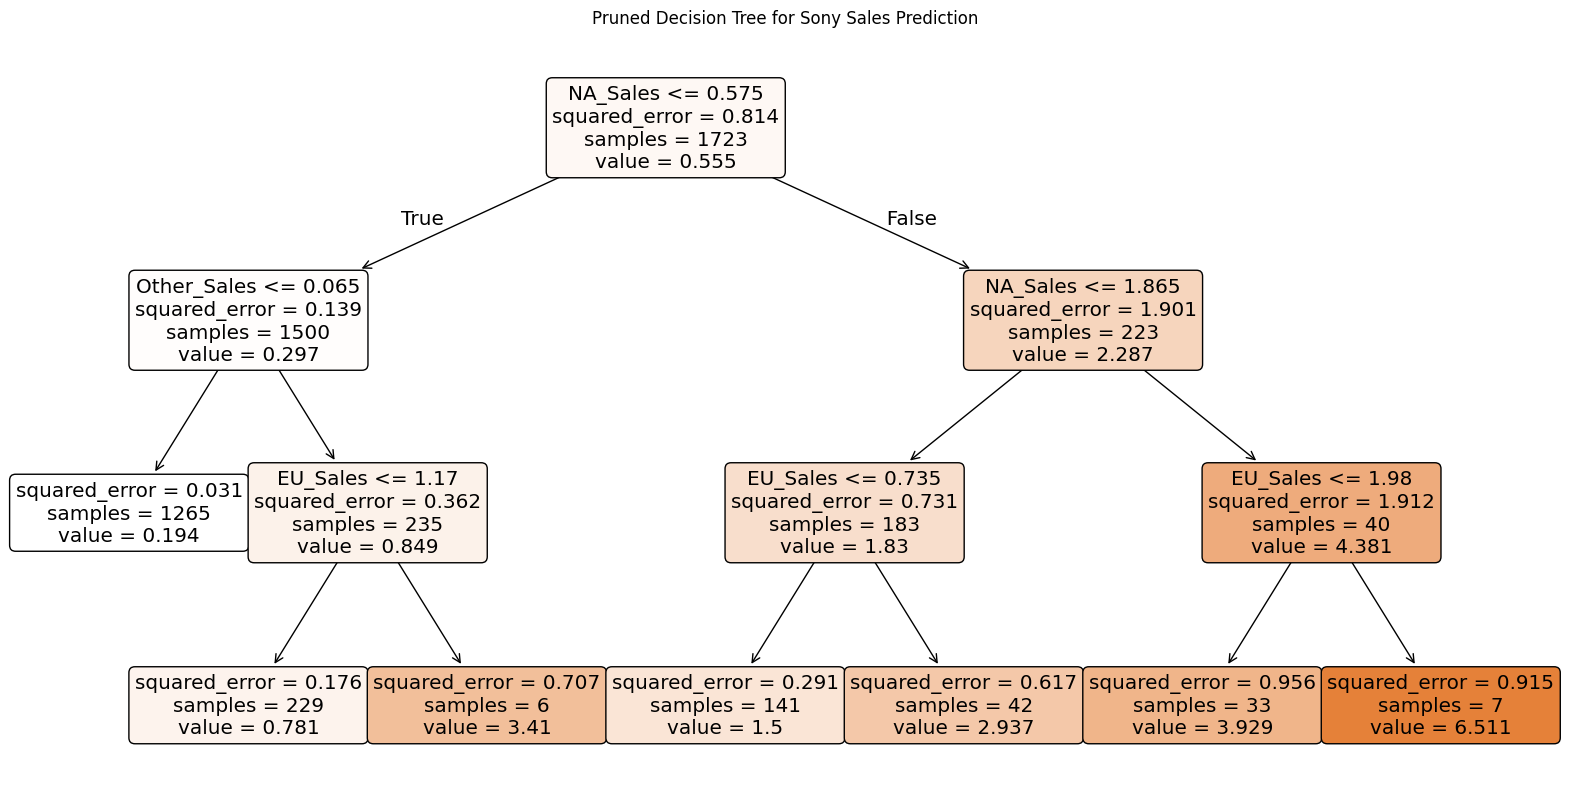

In [ ]:
# Import libraries for post-pruning
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Create a Decision Tree Regressor with hyperparameters
decision_tree = DecisionTreeRegressor(
    max_depth=5,  # Limit tree depth to 5
    min_samples_split=10,  # Require at least 10 samples to split a node
    min_samples_leaf=5,  # Require at least 5 samples in a leaf node
    random_state=42
)

# Define parameter grid for ccp_alpha
param_grid = {
    'ccp_alpha': np.arange(0.0, 0.1, 0.001)  # Explore values between 0 and 0.1
}

# Create and fit GridSearchCV object
tree = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best ccp_alpha value
best_ccp_alpha = grid_search.best_params_['ccp_alpha']
print(f"Best ccp_alpha: {best_ccp_alpha}")

# Create and train the pruned decision tree
# pruned_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=best_ccp_alpha)
pruned_tree = DecisionTreeRegressor(random_state=42, ccp_alpha = 0.01, max_depth = 5)
pruned_tree.fit(X_train, y_train)

# Evaluate the pruned tree
y_pred_pruned = pruned_tree.predict(X_test)
mse_pruned = mean_squared_error(y_test, y_pred_pruned)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error on the PS2 test set (Pruned): {mse_pruned:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

# Visualize the pruned decision tree
plt.figure(figsize=(20, 10))
plot_tree(pruned_tree, feature_names=X.columns, filled=True, rounded=True)
plt.title('Pruned Decision Tree for Sony Sales Prediction')
plt.show()